In [65]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            plot_confusion_matrix)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
import time 

In [3]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/project_3/code'

In [17]:
# country_rock = pd.read_csv('../datasets/country_rock.csv')
# country_rock.head()

In [6]:
country_rock = pd.read_pickle('../datasets/country_rock.pkl')
country_rock.head()

,label,merged,tokens
0,0,country suggestions ve been starting to get in...,"[country, suggestions, ve, been, starting, to,..."
1,0,hank williams sr m so lonesome could cry (1949),"[hank, williams, sr, m, so, lonesome, could, c..."
2,0,cody jinks loud and heavy,"[cody, jinks, loud, and, heavy]"
3,0,"southern raised performs ""what day that will b...","[southern, raised, performs, what, day, that, ..."
4,0,is anybody still making texas swing? my father...,"[is, anybody, still, making, texas, swing, my,..."


In [18]:
# identifying X and y 
X = country_rock['merged']
y = country_rock['label']
    
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                               y, 
                                               test_size=0.25,
                                               shuffle=True,
                                               stratify=y,
                                               random_state=42)

# checking class balance 
print(f'Value counts: \n{y.value_counts(normalize=True)}')

Value counts: 
1    0.5
0    0.5
Name: label, dtype: float64


_Note: While I thought that I had included stop_word removal in my pre-processing, I realized only after doing the above grid searches that I failed to do. I will now start adding stop_word removal to my model benchmarking and will use it in my final models. Excluding my custom `stop_words` (from the list in the cell below) will reduce the accuracy of my model because it prevents a model from using "country" and "rock" which are of course two of most helpful words in determing the class of the subreddit._

_Citation: Thank you Heather Johansen for helping figure out how to include my own custom list of words alongside the English stop words._

In [19]:
country_rock_stop_words = ['country', 'countries', 'rock', 'roll', 'just','song', 'songs', 'music', 
                           'album', 'band', 'bands', 'artist', 'artists', 've', 'don']
all_stop_words = text.ENGLISH_STOP_WORDS.union(country_rock_stop_words)

# Grid Searches for Model Benchmarking 

### _Explanation of System_

#### For all of my grid search models, the following workflow is used to find and evaluate the best model for the chosen vectorizer and estimator pairing.

#### The process is wrapped in the functions below. 

+ Building pipelines according to the following syntax: 

```python
pipe = Pipeline([
        (vec_nickname, vectorizer),
        (est_nickname, estimator)
    ])
```

+ Building Gridsearch parameter dictionaries according the following syntax: 

```python 
param_dict  = {
    'vec_nickname__hyperparameter':[hyperparameter options],
    'est_nickname__hyperparameter':[hyperparameter options]
}
```

+ Building Gridsearch using the following syntax:

```python
grid = GridSearchCV(pipe, 
                   param_dict,
                   cv = 5,
                   verbose = 2,
                   n_jobs=8)

grid.fit(X_train, y_train)
```

+ Building a confusion matrix (where relevant) as follows: 

```python
y_preds = grid.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

plot_confusion_matrix(grid, X_test, y_test, cmap="Blues")  
```

In [9]:
def build_pipe(vec_nickname, vectorizer, est_nickname, estimator):
    pipe = Pipeline([
        (vec_nickname, vectorizer),
        (est_nickname, estimator)
    ])
    return pipe

In [10]:
def grid_search(X_train, y_train, X_test, y_test, est_name, pipe, param_dict):
    
    grid = GridSearchCV(pipe, 
                       param_dict,
                       cv = 5,
                       verbose = 2,
                       n_jobs=8)
    
    grid.fit(X_train, y_train)
    
    print(f'Score for gridsearched {est_name} Pipeline: {grid.best_score_}\n')
    print(f'Best parameters from {est_name} pipeline gridsearch:  {grid.best_params_}\n')
    
    y_preds = grid.predict(X_test)
    
    #confusion matrix
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    plot_confusion_matrix(grid, X_test, y_test, cmap="Blues")      

In [11]:
def model_metrics(model, est_name):
    print(f'Score for gridsearched {est_name} Pipeline: {model.best_score_}\n')
    print(f'Best parameters from {est_name} pipeline gridsearch:  {model.best_params_}\n')
    
    y_preds = model.predict(X_test)
    
    #confusion matrix
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    plot_confusion_matrix(model, X_test, y_test, cmap="Blues")  

## `Logistic Regression`

#### `Countvectorizer + Logistic Regression`

_Below, I am making sure that my function is working by running through the steps outside the function with a Logistic Regression._

In [57]:
logreg_cvec_pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words=all_stop_words)),
        ('logreg', LogisticRegression())
    ])

logreg_cvec_pipe_params = {
    'cvec__max_features':[3000, 4000, 5000],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__min_df': [0.75, 1],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}

logreg_cvec_grid = GridSearchCV(logreg_cvec_pipe, 
                   logreg_cvec_pipe_params,
                   cv = 5,
                   verbose = 2,
                   n_jobs=8)

logreg_cvec_grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.61777778 0.77533333 0.766      0.794      0.77644444 0.78488889
 0.61777778 0.77733333 0.766      0.79155556 0.76355556 0.77977778
 0.61777778 0.77444444 0.76511111 0.78933333 0.76355556 0.77688889
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.61777778 0.78266667 0.76733333 0.80355556 0.78288889 0.79444444
 0.61777778 0.78155556 0.76777778 0.79688889 0.76733333 0.78644444
 0.61777778 0.78088889 0.76777778 0.79688889 0.76533333 0.782
        nan        nan        nan     

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                             

In [43]:
logreg_cvec_grid.score(X_train, y_train)

0.9542222222222222

In [44]:
logreg_cvec_grid.score(X_test, y_test)

0.816

In [21]:
logreg_cvec_grid.best_params_

{'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'logreg__C': 1,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear'}

Score for gridsearched Logistic Regression Pipeline: 0.8039999999999999

Best parameters from Logistic Regression pipeline gridsearch:  {'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}



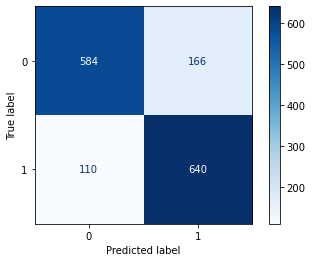

In [22]:
model_metrics(logreg_cvec_grid, 'Logistic Regression')

_Looks like the function is working, but since the function outputs a confusing nonetype object, I will not use and will instead do grid searches manually, outside a functio. I will keep the functions in the notebook in case I need to use any of them. I will be using the `model_metrics` function to get the best parameters, best score, and confusion matrix for each model._ 

#### `Tfidf + Logistic Regression`

In [39]:
logreg_tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=all_stop_words)),
        ('logreg', LogisticRegression())
    ])

logreg_tfidf_pipe_params = {
    'tfidf__max_features':[3000, 4000, 5000],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__min_df': [0.75, 1],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'newton-cg', 'lbfgs']
}

logreg_tfidf_grid = GridSearchCV(logreg_tfidf_pipe, 
                   logreg_tfidf_pipe_params,
                   cv = 5,
                   verbose = 2,
                   n_jobs=8)

logreg_tfidf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.51333333 0.51333333 0.51333333
        nan        nan        nan 0.51333333 0.51333333 0.51333333
        nan        nan        nan 0.50466667 0.50911111 0.50911111
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.77844444 0.77755556 0.77644444
        nan        nan        nan 0.78644444 0.78088889 0.78177778
        nan        nan        nan 0.78711111 0.78444444 0.78555556
        nan        nan        nan

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                            

In [40]:
logreg_tfidf_grid.score(X_train, y_train)

0.924

In [25]:
logreg_tfidf_grid.score(X_test, y_test)

0.822

In [26]:
logreg_cvec_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                             

In [27]:
logreg_tfidf_grid.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'logreg__solver': 'newton-cg',
 'tfidf__max_features': 5000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2)}

Score for gridsearched Logistic Regression w/ TfIdf Pipeline: 0.8064444444444444

Best parameters from Logistic Regression w/ TfIdf pipeline gridsearch:  {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg', 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}



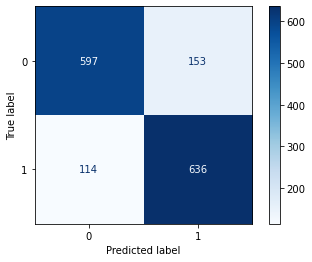

In [28]:
model_metrics(logreg_tfidf_grid, "Logistic Regression w/ TfIdf")

```

pipe = Pipeline([
        (vec_nickname, vectorizer),
        (est_nickname, estimator)
    ])
```

+ Building Gridsearch parameter dictionaries according the following syntax: 

```python 
param_dict  = {
    'vec_nickname__hyperparameter':[hyperparameter options],
    'est_nickname__hyperparameter':[hyperparameter options]
}
```

+ Building Gridsearch using the following syntax:

```python
grid = GridSearchCV(pipe, 
                   param_dict,
                   cv = 5,
                   verbose = 2,
                   n_jobs=8)
```

+ Fitting the grid search on the training data.

```
grid.fit(X_train, y_train)
```

## `Naïve Bayes` 

#### `Naïve Bayes + CountVectorizer`

In [29]:
nb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stop_words)),
    ('nb', MultinomialNB())
])

nb_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__min_df': [0.75, 1],
    'nb__alpha': [0.001, 0.1, 1.0, 10]
}

nb_cvec_grid = GridSearchCV(nb_cvec_pipe,
                            nb_cvec_params,
                            cv=5,
                            verbose=2,
                            n_jobs=8)

In [30]:
nb_cvec_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.76488889 0.76688889 0.76755556 0.75444444 0.75933333 0.75866667
 0.75866667 0.75111111 0.75777778 0.75666667 0.75488889 0.74533333
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.77911111 0.78022222 0.77977778 0.76355556 0.77488889 0.77377778
 0.77288889 0.76533333 0.77288889 0.77155556 0.76888889 0.76155556
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.79222222 0.79244444 0.79022222 0.76955556 0.78244444 0.78222222
 0.78355556 0.77133333 0.77888889 0.78111111 0.78066667 0.774
        nan        nan        nan     

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                             

Score for gridsearched Multinomial Naive Bayes w/ CountVectorizer Pipeline: 0.7955555555555555

Best parameters from Multinomial Naive Bayes w/ CountVectorizer pipeline gridsearch:  {'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.1}



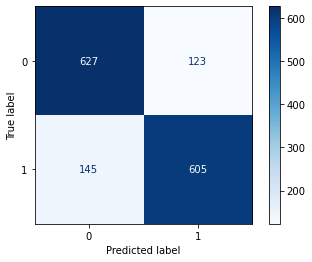

In [31]:
model_metrics(nb_cvec_grid, 'Multinomial Naive Bayes w/ CountVectorizer')

In [32]:
nb_cvec_grid.score(X_train, y_train)

0.9135555555555556

In [33]:
nb_cvec_grid.score(X_test, y_test)

0.8213333333333334

#### `Naïve Bayes + TfIdf` 

_Below I will build pipeline including Multinomial Naive Bayes. Though MNB asks us to have positive integers and Tf-idf does not yield positive integers, fractional counts (such as Tf-Idf) actually to work with multinomial distributions in practice._

_Citation: DSI 5.04-lesson-nlp-ii_

In [34]:
nb_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=all_stop_words)),
    ('nb', MultinomialNB())
])

nb_tfidf_params = {
    'tfidf__max_features': [2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__min_df': [0.75, 1]
}

nb_tfidf_grid = GridSearchCV(nb_tfidf_pipe,
                            nb_tfidf_params,
                            cv=5,
                            verbose=2,
                            n_jobs=8)

In [35]:
nb_tfidf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.77088889 0.76577778 0.76644444
        nan        nan        nan 0.78822222 0.77777778 0.77822222
        nan        nan        nan 0.79555556 0.78733333 0.78577778
        nan        nan        nan 0.79844444 0.79466667 0.79177778]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                            

Score for gridsearched Multinomial Naive Bayes w/ TfIdf Pipeline: 0.7984444444444444

Best parameters from Multinomial Naive Bayes w/ TfIdf pipeline gridsearch:  {'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}



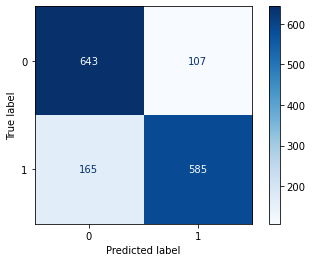

In [36]:
model_metrics(nb_tfidf_grid, 'Multinomial Naive Bayes w/ TfIdf')

In [37]:
nb_tfidf_grid.score(X_train, y_train)

0.924

In [38]:
nb_tfidf_grid.score(X_test, y_test)

0.8186666666666667

_Both of my Naïve Bayes models are about as accurate and as overfit as my Logistic Regression models. Since Logistic Regression is more interpretable for my analysis, I will likely use this as my performance model._

## `k-Nearest Neighbors` 

#### `KNN + CountVectorizer`

In [41]:
knn_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stop_words)),
    ('knn', KNeighborsClassifier())
])

knn_cvec_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'knn__leaf_size': range(1, 50, 5),
    'knn__n_neighbors': range(1, 100, 10),
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

knn_cvec_grid = GridSearchCV(knn_cvec_pipe,
                            knn_cvec_params,
                            cv=5,
                            verbose=2,
                            n_jobs=8)

In [42]:
knn_cvec_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                             

In [152]:
knn_cvec_grid.score(X_train, y_train)

0.9977708426214891

In [153]:
knn_cvec_grid.score(X_test, y_test)

0.6864973262032086

Score for gridsearched KNN w/ Count Vectorization Pipeline: 0.7333911851680807

Best parameters from KNN w/ Count Vectorization pipeline gridsearch:  {'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'knn__leaf_size': 1, 'knn__metric': 'manhattan', 'knn__n_neighbors': 36, 'knn__weights': 'distance'}



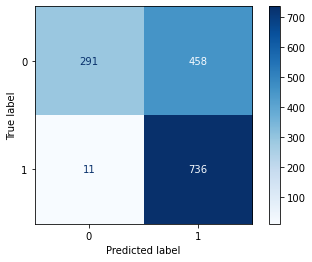

In [155]:
model_metrics(knn_cvec_grid, 'KNN w/ Count Vectorization')

_KNN looks terrible! I don't think this one is going to work._

## `Random Forest & Extra Trees`

#### `Extra Trees Classifier + Count Vectorizer`

_Use of `CountVectorizer` as my vectorizer was informed by a set of pipeline I ran in my practice code notebooks that compared different ensemble classier models paired `CountVectorizer` and `Tfidf Vectorizer`. Extra Trees w/ CountVec performed better (higher accuracy, less variance) than other pairings. Hyperparameters are also informed by the best parameters found in those ensemble model grid searches in a practice code notebook._ 

In [45]:
et_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stop_words)),
    ('et', ExtraTreesClassifier())
])

et_cvec_params = {
    'cvec__max_features':[2000, 3000, 4000],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'et__ccp_alpha': [0.001, 0.05, 0.1, 1],
    'et__max_depth': [6,8,10],
    'et__min_samples_leaf': [4,6,8],
    'et__min_samples_split': [5,10]
}

et_cvec_grid = GridSearchCV(et_cvec_pipe,
                           et_cvec_params,
                           cv=5,
                           verbose=2,
                           n_jobs=8)

In [46]:
# this time going to try it!
import time 
t0 = time.time()

et_cvec_grid.fit(X_train, y_train)

print(f'This cell took {time.time() - t0} seconds to run')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
This cell took 494.62858414649963 seconds to run


In [47]:
et_cvec_grid.best_score_

0.6913333333333334

In [58]:
et_cvec_grid.score(X_train, y_train)

0.7242222222222222

In [60]:
et_cvec_grid.score(X_test, y_test)

0.7066666666666667

Score for gridsearched Extra Trees Classifier w/ CountVectorizer  Pipeline: 0.6913333333333334

Best parameters from Extra Trees Classifier w/ CountVectorizer  pipeline gridsearch:  {'cvec__max_features': 4000, 'cvec__ngram_range': (1, 1), 'et__ccp_alpha': 0.001, 'et__max_depth': 10, 'et__min_samples_leaf': 4, 'et__min_samples_split': 10}



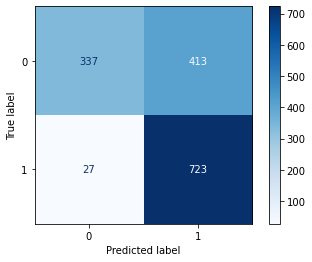

In [62]:
model_metrics(et_cvec_grid, "Extra Trees Classifier w/ CountVectorizer ")

#### `Random Forest Classifier + Tf-Idf Vectorizer`

In [48]:
rf_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=all_stop_words)),
    ('rf', RandomForestClassifier())
])

rf_tfidf_params = {
    'tfidf__max_features': [2000, 3000, 4000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__ccp_alpha': [0.001, 0.1],
    'rf__max_depth': [6, 8, 10],
    'rf__min_samples_leaf': [6, 8],
    'rf__min_samples_split': [3, 5, 8], 
    'rf__n_estimators': [50, 150, 250],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__warm_start': [True, False]
}

rf_tfidf_grid = GridSearchCV(rf_tfidf_pipe,
                            rf_tfidf_params,
                            cv=5, 
                            verbose=2,
                            n_jobs=8)

In [49]:
rf_tfidf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'album',
                                                                              'all',
                                                            

In [50]:
rf_tfidf_grid.score(X_train, y_train)

0.7517777777777778

In [51]:
rf_tfidf_grid.score(X_test, y_test) 

0.7193333333333334

Score for gridsearched Random Forest Classifier w/ Tf-Idf Vectorizer Pipeline: 0.7095555555555555

Best parameters from Random Forest Classifier w/ Tf-Idf Vectorizer pipeline gridsearch:  {'rf__ccp_alpha': 0.001, 'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 8, 'rf__n_estimators': 250, 'rf__warm_start': False, 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 1)}



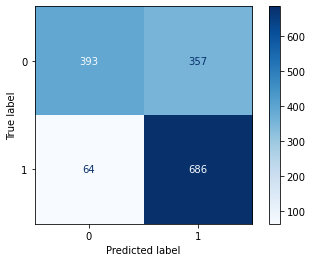

In [63]:
model_metrics(rf_tfidf_grid, "Random Forest Classifier w/ Tf-Idf Vectorizer")

_Thanks to massive grid searches, my Random Forest and Extra Trees models sacrifice some accuracy but are much less overfit than my Logistic Regression models. Since I feel much more excited about interpreting and promoting the Logistic Regression, and because fitting and accuracy are not my main goal, I will use Logistic Regression instead of the trees models for my final product._

## `Support Vector Machines`

#### `SVC + Count Vectorizer`

In [52]:
svc_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stop_words)),
    ('svc', SVC())
])

svc_cvec_params = {
    'cvec__max_features':[2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'svc__gamma': ['scale', 'auto'],
    'svc__tol': [0.001, 0.01],
    'svc__C': np.linspace(0, 5, 20),
    'svc__kernel':['linear', 'rbf', 'polynomial', 'sigmoid'],
    'svc__degree':[1, 2, 3, 4]
}

svc_cvec_grid = GridSearchCV(svc_cvec_pipe,
                             svc_cvec_params,
                             cv=5,
                             verbose=2,
                             n_jobs=8)

In [53]:
t0 = time.time()

svc_cvec_grid.fit(X_train, y_train)

print(f'This cell took {time.time() - t0} seconds to run')

Fitting 5 folds for each of 7680 candidates, totalling 38400 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ...        nan 0.73511111 0.73533333]
  warnings.warn(


This cell took 17141.273571014404 seconds to run


In [54]:
svc_cvec_grid.score(X_train, y_train)

0.9366666666666666

In [55]:
svc_cvec_grid.score(X_test, y_test)

0.804

In [56]:
svc_cvec_grid.best_params_

{'cvec__max_features': 5000,
 'cvec__ngram_range': (1, 1),
 'svc__C': 0.2631578947368421,
 'svc__degree': 1,
 'svc__kernel': 'linear',
 'svc__tol': 0.001}

Score for gridsearched Support Vector Machine Classifier w/ CountVectorizer Pipeline: 0.7988888888888889

Best parameters from Support Vector Machine Classifier w/ CountVectorizer pipeline gridsearch:  {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'svc__C': 0.2631578947368421, 'svc__degree': 1, 'svc__kernel': 'linear', 'svc__tol': 0.001}



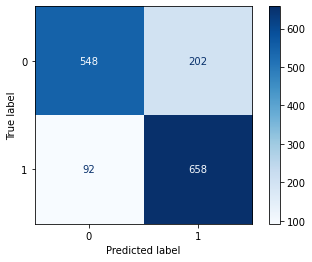

In [66]:
model_metrics(svc_cvec_grid, "Support Vector Machine Classifier w/ CountVectorizer")

_The support vector classifier model is overfit and not that accurate. But I'm glad that I tried it!_